# Peeking Simulator

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.power import TTestIndPower
from scipy.stats import norm
import scipy.stats as stats

# One A/A Test

When conducting an A/A test, the variant is not different from the control. In the context of online A/B testing, traffic is split into two different pages (A & B) to see which version is better. In A/A tests, both version are exactly the same. This articule explores why would implement A/A tests in the first place: https://vwo.com/blog/aa-test-before-ab-testing/


Since both variants are the same though, we would not expect any variant to be "better" than the other. If correctly implemented, we should find one variant to be statistically different from the other, 5% of the time, as indicated by our alpha/false positive probability.

To make sure both variants are the same, I'll be drawing sample from the standard normal distirbution which has mean 0 and std 1. The plot below shows that both distributions come from the same population.




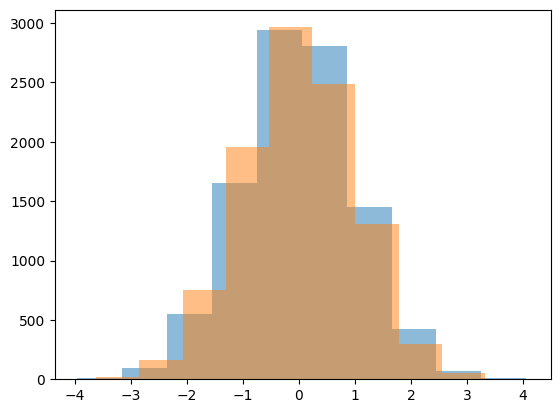

In [35]:
control = np.random.standard_normal(size=10000) # Variant 1
treatment = np.random.standard_normal(size=10000) # Variant 2
plt.hist(control, alpha=0.5)
plt.hist(treatment, alpha=0.5)
plt.show()

Now that we have our two variants for the A/A test, we will design our experiment to have a 5% false positive probability. That is, on average, if we were to run 100 identical experiments, 5 of them will have a p-value lower than alpha, indicating a statistical significant result.


Since we know they are not different, those conclusions would be wrong.

In [6]:
effect_size = 0.035
alpha = 0.05 # significance level, false positive probability
power = 0.8 # probability of correctly rejecting the null hypothesis

power_analysis = TTestIndPower()
sample_size = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='larger')
print(f"Sample size per group: {sample_size:.0f}")

Sample size per group: 10095


In [7]:
point_estimate_lst = []
sample_lst = []
confidence_level_lst = []
p_value_lst = []

for n in range(3,round(sample_size)+3, 1000):
    control = np.random.standard_normal(size=n)
    treatment = np.random.standard_normal(size=n) 
    t_statistic, p_value = stats.ttest_ind(control, treatment)

    confidence_level_lst.append(1 - p_value)
    p_value_lst.append(p_value)
    sample_lst.append(n)

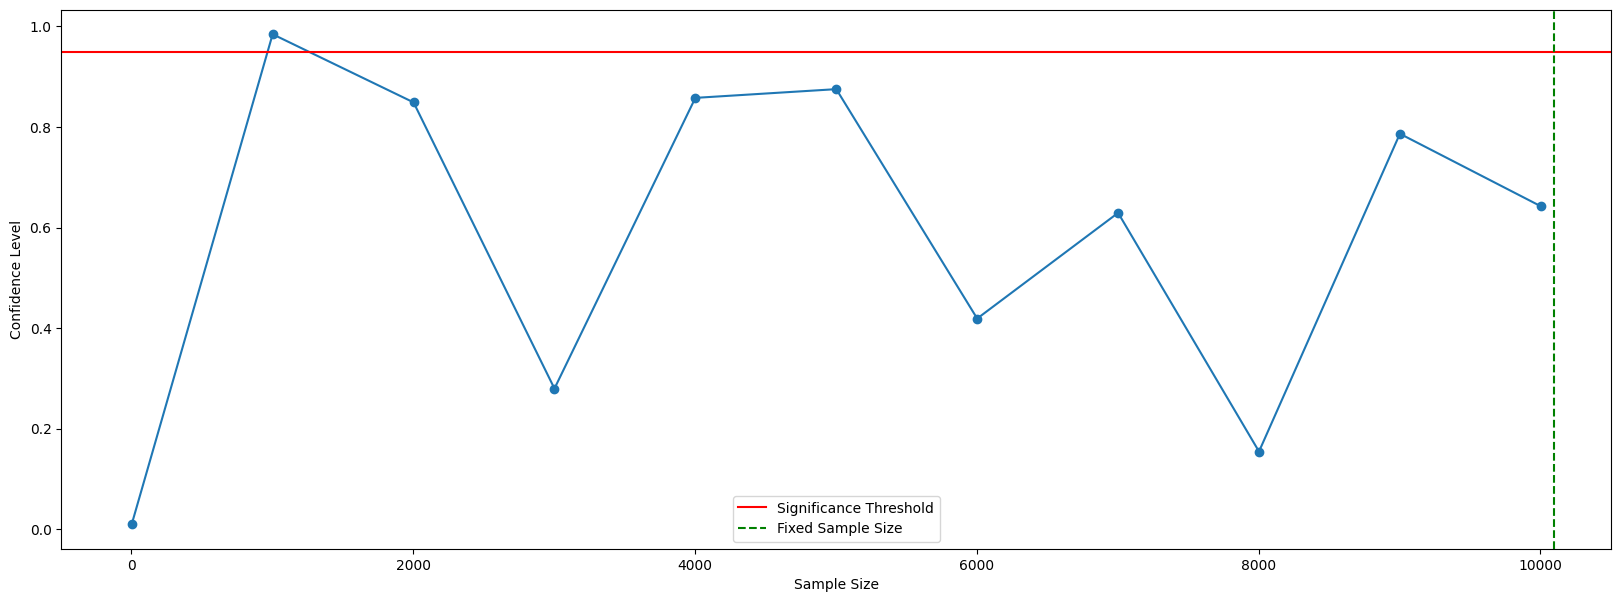

In [8]:
plt.figure(figsize=(20,7))
plt.plot(sample_lst,confidence_level_lst, marker='o')
plt.axhline(1-alpha, c='red', label='Significance Threshold')
plt.axvline(round(sample_size), c='green', label='Fixed Sample Size', ls='--')
plt.ylabel("Confidence Level")
plt.xlabel("Sample Size")
plt.legend()
plt.show()

### Single A/A Test. How is the Type 1 Error Inflated?


- In **Fixed Size Sample Testing**, you commit to how many observations you will collect (green dashed line) before evaluating your experiment. If you stop your experiment before the required sample size, you're peeking and therefore inflating your Type 1 error probability.

- The validity of the statement that you have a 5% False Positive probability as indicated by alpha comes from the fact that run the experiment all the way until the green dashed line. For example, If you were to run 100 A/A tests where you allow it to run all the way to the green dashed line, on average 5 of those will detect a difference, which is being above the red line (Type 1 error).

### Suppose significance is declared is less than a cutoff alpha. Then:

In [31]:
aa_tests = []
peeking_lst = []

for _ in range(1000): # 100 A/A tests

    sample_lst = []
    confidence_level_lst = []
    p_value_lst = []

    for n in range(3,round(sample_size)+3, 1000):
        control = np.random.standard_normal(size=n)
        treatment = np.random.standard_normal(size=n) 
        t_statistic, p_value = stats.ttest_ind(control, treatment)

        confidence_level_lst.append(1 - p_value)
        p_value_lst.append(p_value)
        sample_lst.append(n)

    peeking_lst.append( any([1 if i < alpha else 0 for i in p_value_lst]) )
    aa_tests.append(p_value_lst[-1]<alpha)

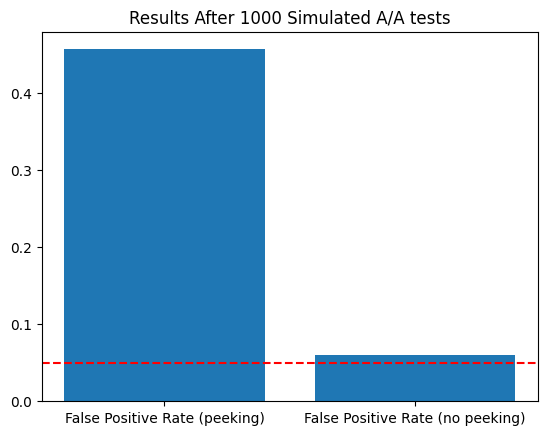

In [30]:
data = {"False Positive Rate (peeking)": sum(peeking_lst) / 1000, "False Positive Rate (no peeking)": sum(aa_tests) / 1000}

plt.bar(data.keys(), data.values())
plt.title("Results After 1000 Simulated A/A tests")
plt.axhline(alpha, c='red', label='Significance Level', ls='dashed')
plt.show()

In [29]:

def aa_test_simulation(sample_size):
    aa_tests = []
    peeking_lst = []

    for _ in range(100): # running 100 A/A Tests

        point_estimate_lst = []
        sample_lst = []
        confidence_level_lst = []
        p_value_lst = []

        for n in range(3,round(sample_size)+3, int(np.floor(60002 / 10))):

            control = np.random.standard_normal(size=n)
            treatment = np.random.standard_normal(size=n) 
            point_estimate = (control - treatment).mean()
            
            pooled_se = pooled_standard_error(s1=control.std(), s2=treatment.std(), n1=n, n2=n)
            z = point_estimate / pooled_se
            p_value = z_to_p_value(z, two_tailed=False)

            confidence_level_lst.append(1 - p_value)
            p_value_lst.append(p_value)
            point_estimate_lst.append(point_estimate)
            sample_lst.append(n)

        peeking_lst.append( any([1 if i < alpha else 0 for i in p_value_lst]) )
        aa_tests.append(p_value_lst[-1]<alpha)

    return sum(peeking_lst)/100, sum(aa_tests)/100

    

In [30]:
sample_size=[i for i in range(2,61000+2, 3000)]
peeking_lst = []
aa_test_lst = []

for sample in sample_size:
    peeking, aa_test = aa_test_simulation(sample_size=sample)
    peeking_lst.append(peeking)
    aa_test_lst.append(aa_test)


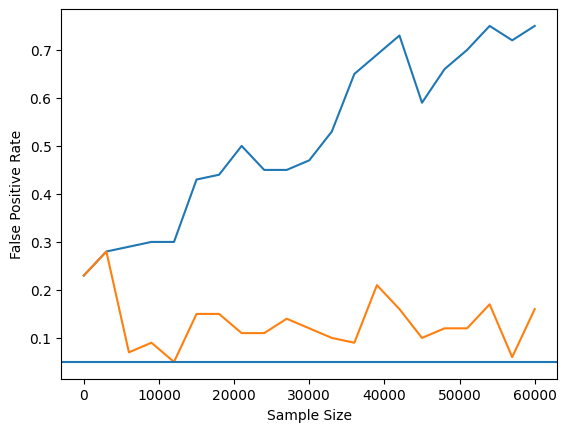

In [31]:
plt.plot(sample_size,peeking_lst)
plt.plot(sample_size,aa_test_lst)
plt.ylabel("False Positive Rate")
plt.xlabel("Sample Size")
plt.axhline(alpha, label='Prestablished Alpha')
plt.show()


Test

In [4]:
effect_sizes = [0.08, 0.05, 0.04, 0.035, 0.029]

alpha = 0.05 # significance level, false positive probability
power = 0.8 # probability of correctly rejecting the null hypothesis

for effect_size in effect_sizes:
    power_analysis = TTestIndPower()
    sample_size = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='larger')
    print(round(sample_size))
    # print(f"Sample size per group: {sample_size:.0f}")

1933
4947
7729
10095
14704


In [ ]:
# effect_size_dict = {'aa': {}, 'peek': {}}

# for effect_size in effect_sizes:

#     power_analysis = TTestIndPower()
#     sample_size = round(power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='larger'))

#     aa_tests = []
#     peeking_lst = []

#     for _ in range(1000): # running 100 A/A Tests

#         point_estimate_lst = []
#         sample_lst = []
#         confidence_level_lst = []
#         p_value_lst = []

#         #for n in range(3, sample_size, int(np.floor(round(sample_size) / 10)) ):

#         control = np.random.standard_normal(size=sample_size)
#         treatment = np.random.standard_normal(size=sample_size) 
#         point_estimate = (control - treatment).mean()

#         pooled_se = pooled_standard_error(s1=control.std(), s2=treatment.std(), n1=sample_size, n2=sample_size)
#         z = point_estimate / pooled_se
#         p_value = z_to_p_value(z, two_tailed=False)

#         confidence_level_lst.append(1 - p_value)
#         p_value_lst.append(p_value)
#         point_estimate_lst.append(point_estimate)
#         sample_lst.append(sample_size)

#         peeking_lst.append( any([1 if i < alpha else 0 for i in p_value_lst]) )
#         aa_tests.append(p_value_lst[-1]<alpha)

#     effect_size_dict['aa'][sample_size] = sum(aa_tests)/len(aa_tests) 
#     effect_size_dict['peek'][sample_size] = sum(peeking_lst)/len(peeking_lst) 

# Sequential Testing

In [120]:
n_lst = []
mean_lst = []
std_error_lst = []
std_error_log_lst = []

for n in range(10,10000, 1):
    mean  = np.random.standard_normal(size=n).mean()
    n_lst.append(n)
    mean_lst.append(mean)
    std_error_lst.append(1/np.sqrt(n))
    std_error_log_lst.append(np.sqrt(np.log(n)/n))

Text(0, 0.5, 'Sample Mean')

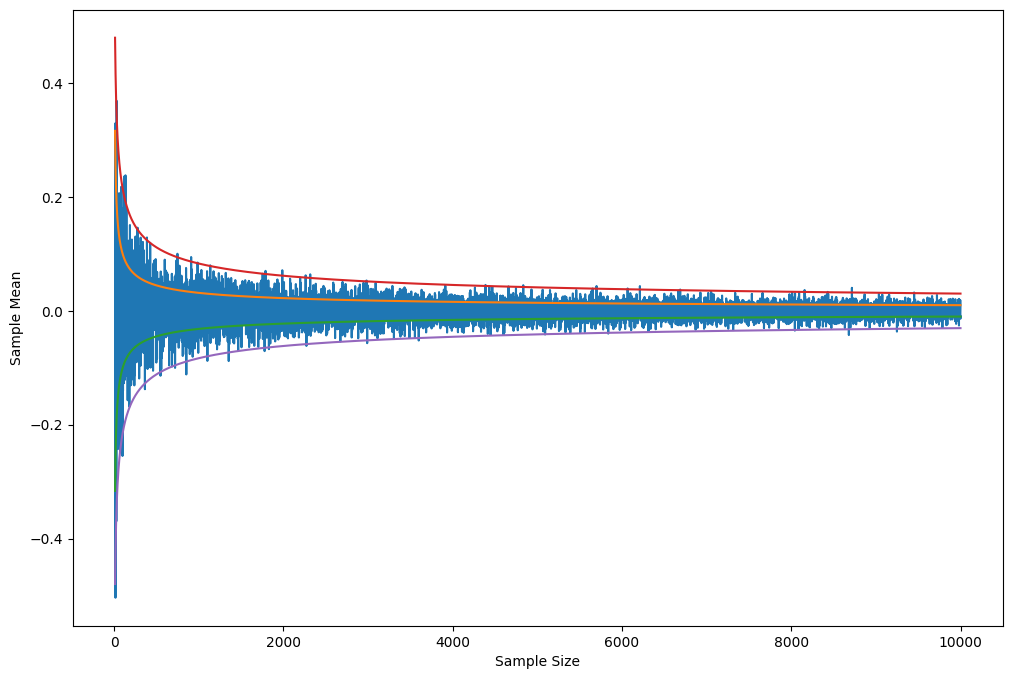

In [121]:
plt.figure(figsize=(12,8))
plt.plot(n_lst, mean_lst)
plt.plot(n_lst, std_error_lst)
plt.plot(n_lst, [-1*i for i in std_error_lst])

plt.plot(n_lst, std_error_log_lst)
plt.plot(n_lst, [-1*i for i in std_error_log_lst])
plt.xlabel("Sample Size")
plt.ylabel("Sample Mean")

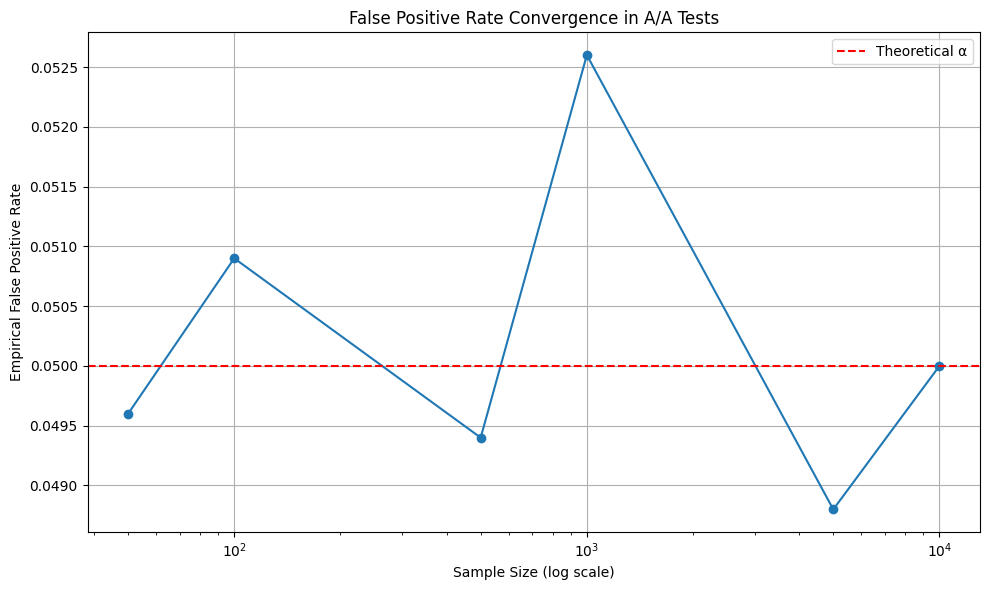

Sample Size | False Positive Rate
-----------------------------------
         50 | 0.0496
        100 | 0.0509
        500 | 0.0494
       1000 | 0.0526
       5000 | 0.0488
      10000 | 0.0500


In [46]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def simulate_aa_test(sample_size, num_simulations=1000, alpha=0.05):
    """
    Simulate A/A tests to check false positive rate convergence
    
    Parameters:
    - sample_size: Number of samples in each group
    - num_simulations: Number of A/A test simulations to run
    - alpha: Significance level
    
    Returns:
    - Empirical false positive rate
    """
    # Track number of false positives (Type I errors)
    false_positives = 0
    
    for _ in range(num_simulations):
        # Generate two independent samples from standard normal distribution
        group_a1 = np.random.standard_normal(sample_size)
        group_a2 = np.random.standard_normal(sample_size)
        
        # Perform two-sample t-test
        t_statistic, p_value = stats.ttest_ind(group_a1, group_a2)
        
        # Check if null hypothesis is rejected
        if p_value < alpha:
            false_positives += 1
    
    # Calculate empirical false positive rate
    false_positive_rate = false_positives / num_simulations
    
    return false_positive_rate

# Simulate for different sample sizes
sample_sizes = [50, 100, 500, 1000, 5000, 10000]
alpha = 0.05
results = []

for n in sample_sizes:
    false_positive_rate = simulate_aa_test(n, alpha=alpha)
    results.append((n, false_positive_rate))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, [r[1] for r in results], marker='o')
plt.axhline(y=alpha, color='r', linestyle='--', label='Theoretical α')
plt.xscale('log')
plt.xlabel('Sample Size (log scale)')
plt.ylabel('Empirical False Positive Rate')
plt.title('False Positive Rate Convergence in A/A Tests')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print detailed results
print("Sample Size | False Positive Rate")
print("-" * 35)
for n, rate in results:
    print(f"{n:11d} | {rate:.4f}")